# Afriat

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

In [3]:
torch.cuda.is_available()

False

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
from harmony import harmonize

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
sc.pp.pca(adata)

In [7]:
adata.obsm["harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key=[])

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [8]:
vaes = dict()
reserveds = dict()

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "afriat_v1_1"
)
vaes["status_control"] = tardis.MyModel.load(dir_path=dir_path, adata=adata)
from tardis._disentanglementmanager import DisentanglementManager as DM
reserveds["status_control"] = {config.obs_key: config.reserved_latent_indices for config in DM.configurations.items}
reserveds["status_control"]["unreserved_complete"] = DM.configurations.unreserved_latent_indices

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "afriat_v3_1"
)
vaes["zone"] = tardis.MyModel.load(dir_path=dir_path, adata=adata)
from tardis._disentanglementmanager import DisentanglementManager as DM
reserveds["zone"] = {config.obs_key: config.reserved_latent_indices for config in DM.configurations.items}
reserveds["zone"]["unreserved_complete"] = DM.configurations.unreserved_latent_indices

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "afriat_v4_1"
)
vaes["time_cat"] = tardis.MyModel.load(dir_path=dir_path, adata=adata)
from tardis._disentanglementmanager import DisentanglementManager as DM
reserveds["time_cat"] = {config.obs_key: config.reserved_latent_indices for config in DM.configurations.items}
reserveds["time_cat"]["unreserved_complete"] = DM.configurations.unreserved_latent_indices

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "afriat_v2_4_1"
)
vaes["triple"] = tardis.MyModel.load(dir_path=dir_path, adata=adata)
from tardis._disentanglementmanager import DisentanglementManager as DM
reserveds["triple"] = {config.obs_key: config.reserved_latent_indices for config in DM.configurations.items}
reserveds["triple"]["unreserved_complete"] = DM.configurations.unreserved_latent_indices

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "afriat_scvi"
)
vaes["scvi"] = tardis.MyModel.load(dir_path=dir_path, adata=adata)
reserveds["scvi"] = dict()
reserveds["scvi"]["unreserved_complete"] = list(range(24))

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(


INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v1_1/model.pt already downloaded


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/model/base/_base_model.py:699: UserWarning: `(None, ['zone', 'time_cat'])` is defined as `batch_key` or `categorical_covariate`, it will be given to both encoder and decoder. Make sure this does not contain information of any of your disentenglement targets. For example, if `donor_id` is chosen as a batch key, do not disentengle donor level information such as `sex` or `age`. The decoder should not use the disentengled latent spaces, simply ignores, if it is already given a batch_key. 
  getattr(cls, method_name)(adata, source_registry=registry, **registry[_SETUP_ARGS_KEY])


INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v3_1/model.pt already downloaded


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/model/base/_base_model.py:699: UserWarning: `(None, ['status_control', 'time_cat'])` is defined as `batch_key` or `categorical_covariate`, it will be given to both encoder and decoder. Make sure this does not contain information of any of your disen

INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v4_1/model.pt already downloaded


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/model/base/_base_model.py:699: UserWarning: `(None, ['status_control', 'zone'])` is defined as `batch_key` or `categorical_covariate`, it will be given to both encoder and decoder. Make sure this does not contain information of any of your disenteng

INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_v2_4_1/model.pt already         
         downloaded                                                                                                


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/afriat_scvi/model.pt already downloaded


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [9]:
for k in vaes:
    adata.obs[f"validation_{k}"] = "train"
    adata.obs[f"validation_{k}"].iloc[vaes[k].validation_indices] = "validation"

/tmp/ipykernel_1692784/2097264642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[f"validation_{k}"].iloc[vaes[k].validation_indices] = "validation"
/tmp/ipykernel_1692784/2097264642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[f"validation_{k}"].iloc[vaes[k].validation_indices] = "validation"
/tmp/ipykernel_1692784/2097264642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[f"validation_{k}"

In [10]:
for k in vaes:
    adata.obsm[f"latent_{k}"] = vaes[k].get_latent_representation()

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/hom

In [11]:
adata.uns["reserveds"] = reserveds

In [12]:
for k in adata.uns["reserveds"]:
    adata.obsm[f"latent_{k}_unreserved"] = adata.obsm[f"latent_{k}"][:, adata.uns["reserveds"][k]["unreserved_complete"]].copy()

In [13]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

In [18]:
# methods without batch key
batchcor = BatchCorrection(
    silhouette_batch=False,
    ilisi_knn=False,
    kbet_per_label=False,
    graph_connectivity=True,
    pcr_comparison=True
)

biocons = BioConservation(
    isolated_labels=False,
    nmi_ari_cluster_labels_leiden=True,
    nmi_ari_cluster_labels_kmeans=False,
    silhouette_label=True,
    clisi_knn=True
)

In [19]:
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control', '_scvi_batch', '_scvi_labels', 'validation_status_control', 'validation_zone', 'validation_time_cat', 'validation_triple', 'validation_scvi'
    uns: 'log1p', 'pca', '_scvi_uuid', '_scvi_manager_uuid', 'reserveds'
    obsm: 'X_pca', 'harmony', '_scvi_extra_categorical_covs', '_scvi_disentanglement_target', '_scvi_metrics_helper', 'latent_status_control', 'latent_zone', 'latent_time_cat', 'latent_triple', 'latent_scvi', 'latent_status_control_unreserved', 'latent_zone_unreserved', 'latent_time_cat_unreserved', 'latent_triple_unreserved', 'latent_scvi_unreserved'
    varm: 'PCs'
    layers: 'counts'

In [20]:
bm = Benchmarker(
    adata=adata,
    batch_key="experiment",  # placeholder
    label_key="mouse",
    embedding_obsm_keys=['latent_zone_unreserved', 'latent_time_cat_unreserved', 'latent_status_control_unreserved', 'latent_triple_unreserved', 'latent_scvi_unreserved', 'harmony', 'X_pca'],
    pre_integrated_embedding_obsm_key='X_pca',  # equals to X_pca
    bio_conservation_metrics=biocons,
    batch_correction_metrics=batchcor,
    n_jobs=-1,
)
bm.benchmark()

Metrics:  40%|█████████████████████████████████████████████████▏                                                                         | 4/10 [00:07<00:10,  1.78s/it, Batch correction: pcr_comparison]/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(

Metrics:   0%|                                                                                                                                                                     | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                          
Metrics:  40%|█████████████████████████████████████████████████▏                                                                     

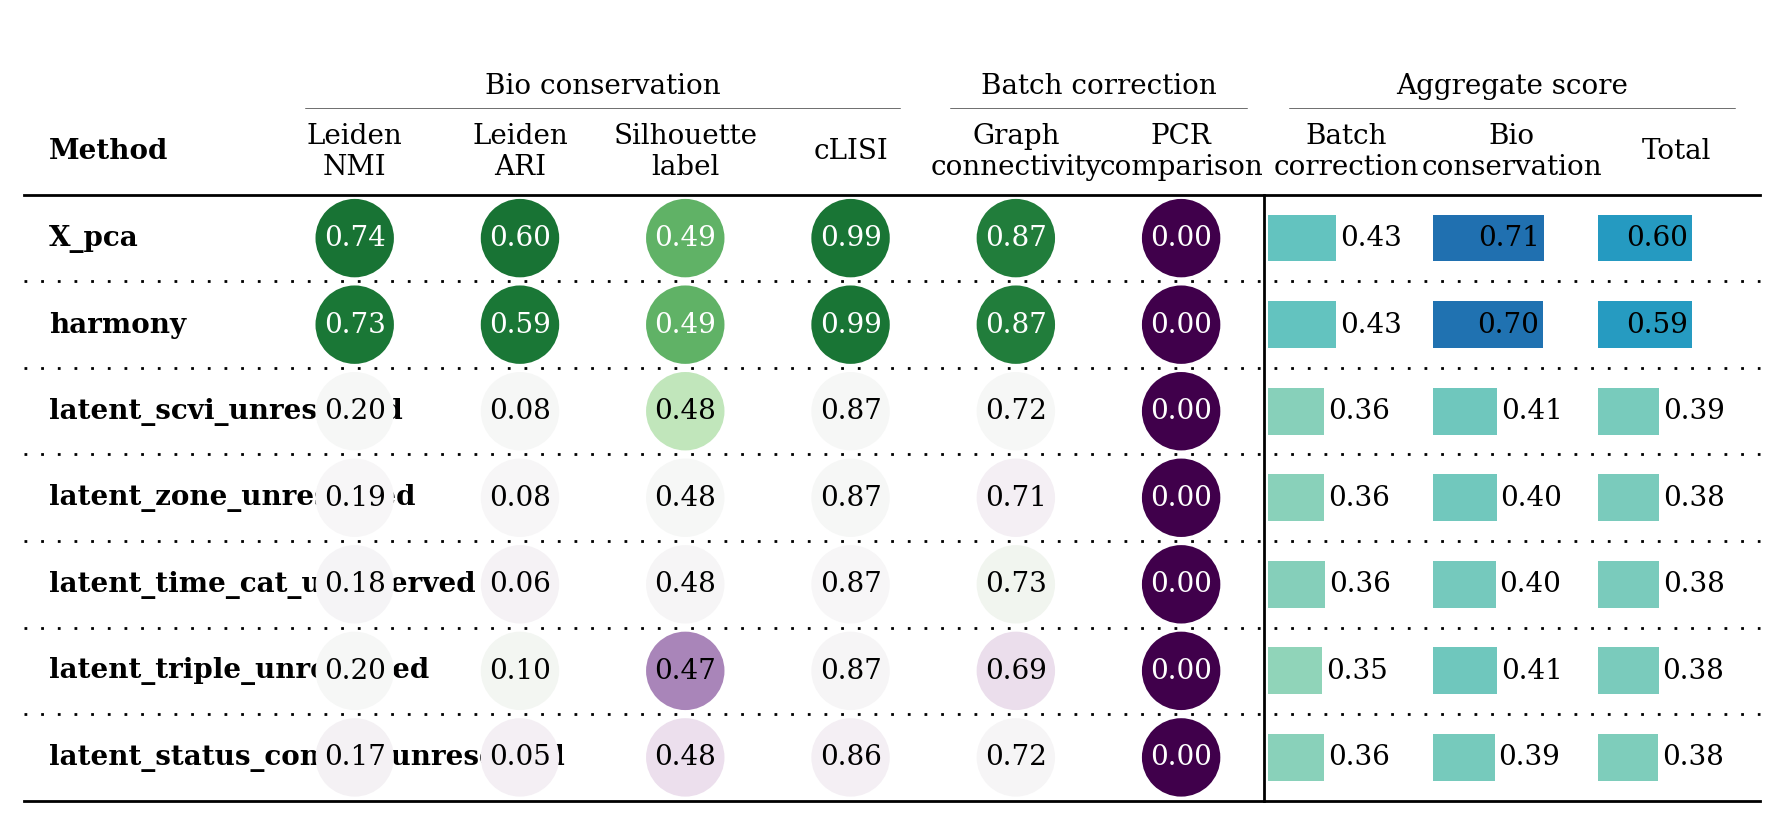

In [21]:
bm.plot_results_table(min_max_scale=False, show=False)

In [23]:
bm.get_results(min_max_scale=False)[['Leiden NMI', 'Leiden ARI', 'Silhouette label', 'cLISI']]

,Leiden NMI,Leiden ARI,Silhouette label,cLISI
Embedding,,,,
latent_zone_unreserved,0.194606,0.077025,0.479616,0.866513
latent_time_cat_unreserved,0.183694,0.063633,0.479391,0.865837
latent_status_control_unreserved,0.174686,0.054115,0.477604,0.859622
latent_triple_unreserved,0.198453,0.097521,0.471731,0.865096
latent_scvi_unreserved,0.198815,0.080673,0.48406,0.867253
harmony,0.732801,0.585982,0.488366,0.993812
X_pca,0.744922,0.596448,0.488366,0.993812
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation


In [24]:
# Note that this is not reported because `batch_key` or `label_key` is not true label/batch keys. it is meaningless.